In [30]:
from mltools import *
#from tme5 import *
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:

def descente_gradient(datax, datay, f_loss, f_grad, eps, iter,init_null):
    if init_null==1:
        w_old = np.ones(shape=(datax.shape[1], 1))
    else:
        w_old = np.random.randn(datax.shape[1],1)
    all_w = [w_old]
    loss = [f_loss(w_old, datax, datay).mean()]

    for i in range(iter):
        w = w_old - eps * f_grad(w_old, datax, datay).mean(0).reshape(-1,1)
        all_w.append(w.copy())
        loss.append(f_loss(w, datax, datay).mean())
        if (np.abs((w - w_old)) < 1e-6).all():
            print("Convergence : ",i+1)
            #break
            return w, all_w, loss
        w_old=w


    print("Pas de convergence")
    return w, all_w, loss

In [32]:
def perceptron_loss(w, x, y):
    preds = x @ w
    return np.maximum(np.zeros_like(preds), - y * preds)

def perceptron_grad(w, x, y):
    n, d = x.shape
    zero_loss = np.nonzero(perceptron_loss(w, x, y) == 0)[0]
    grad = -y.reshape(n, 1) * x
    grad[zero_loss] = np.zeros(d)
    return grad

In [33]:
class Lineaire(object):
    def __init__(self, loss=perceptron_loss, loss_g=perceptron_grad, max_iter=100, eps=0.01,init_mode=0):
        self.max_iter, self.eps = max_iter, eps
        self.w = None
        self.loss, self.loss_g = loss, loss_g
        self.init_mode=init_mode

        self.w_list, self.loss_list = [], []

    def fit(self, datax, datay):
        self.w, self.w_list, self.loss_list = descente_gradient(
            datax, datay, self.loss, self.loss_g, self.eps, self.max_iter,self.init_mode)

    def predict(self, datax):
        return np.sign(datax @ self.w).flatten()

    def score(self, datax, datay):
        y_hat = self.predict(datax)
        if datay.shape != y_hat.shape:
            datay = datay.flatten()
        return (np.where(datay == y_hat, 1, 0)/len(datay)).sum()

Pas de convergence


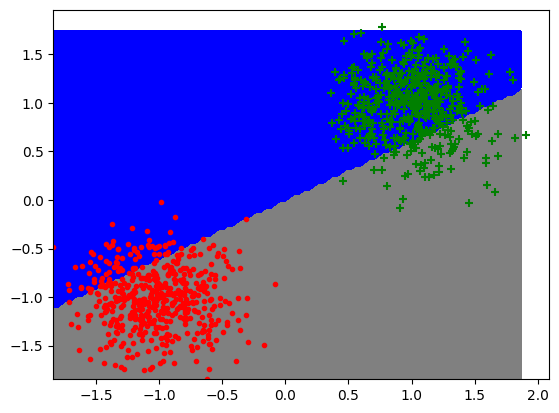

In [34]:
datax,datay=gen_arti()
trainx,testx,trainy,testy=train_test_split(datax,datay,train_size=0.1)
cl=Lineaire()
cl.fit(trainx,trainy)
cl.score(testx,testy)
plot_frontiere(datax, lambda x: np.sign(x.dot(cl.w)), step=100)
plot_data(datax,datay)


In [35]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

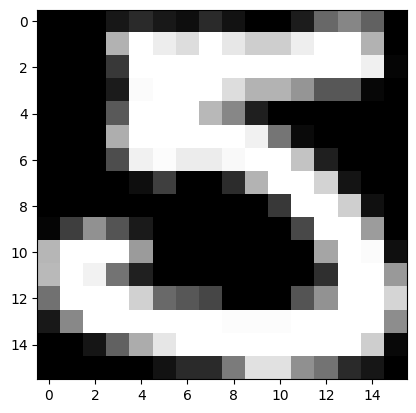

In [36]:
uspsdatatrain = "../data/USPS_train.txt"
uspsdatatest = "../data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
neg = 5
pos = 6
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)
show_usps(datax[0])



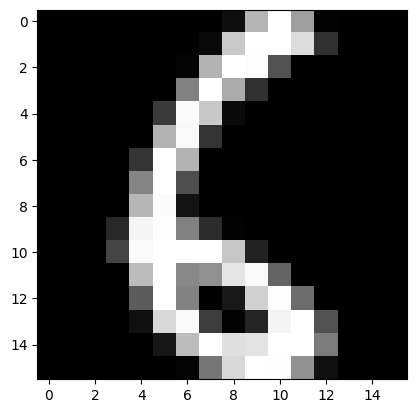

In [37]:
show_usps(datax[-1])

### Random init

In [38]:
datax, datay = get_usps(6, alltrainx, alltrainy)
testx, testy = get_usps(6, alltestx, alltesty)
datay = np.where(datay==6, -1, 1).reshape(-1, 1)
testy = np.where(testy==6, -1, 1).reshape(-1, 1)
cl_random=Lineaire(max_iter=1000)
cl_random.fit(datax,datay)
score_test=cl_random.score(testx,testy)
score_train=cl_random.score(datax,datay)
print("Score sur les données de test :",score_test)
print("Score sur les données de entrainement :",score_train)
print("Loss :",cl_random.loss_list[-1])

Pas de convergence
Score sur les données de test : 0.9941176470588234
Score sur les données de entrainement : 0.9984939759036143
Loss : 0.0032682714769852587


### Ones init


In [39]:
cl_ones=Lineaire(max_iter=1000,init_mode=1)
cl_ones.fit(datax,datay)
score_test=cl_ones.score(testx,testy)
score_train=cl_ones.score(datax,datay)
print("Score sur les données de test :",score_test)
print("Score sur les données de entrainement :",score_train)
print("Loss :",cl_ones.loss_list[-1])

Pas de convergence
Score sur les données de test : 0.9823529411764704
Score sur les données de entrainement : 0.9879518072289155
Loss : 0.09502908327988985


## Projection

In [40]:

def proj_poly(X):
    n, d = X.shape
    d_ = int(1 + 2*d + (d *(d-1)/2))
    X_ = np.zeros((n, d_))
    X_[:, 0] = 1
    k = 2*d
    for j in range(d):
        X_[:, j+1] = X[:, j]
        X_[:, j+1+d] = X[:, j]**2
        for i in range(j+1,d):
            k += 1
            X_[:, k] = X[:, j] * X[:, i]
    return X_

def proj_biais(X):
    return np.append(X, np.ones((len(X), 1)),axis=1)

def proj_gauss(X, base, sigma):
    assert X.shape[1] == base.shape[1]
    return np.array([(((x - base)**2).sum(1) / 2*sigma) for x in X])

In [43]:
x_poly=proj_poly(datax)
x_poly_test=proj_poly(testx)
cl_poly=Lineaire(max_iter=1000)
cl_poly.fit(x_poly,datay)
print("Test score :",cl_poly.score(x_poly_test,testy) )
print("Train score :",cl_poly.score(x_poly,datay))
print("Loss :",cl_poly.loss_list[-1])

Convergence :  431
Test score : 0.9999999999999999
Train score : 0.9999999999999999
Loss : 0.0


In [46]:
x_biais=proj_biais(datax)
x_biais_test=proj_biais(testx)
cl_biais=Lineaire(max_iter=1000)
cl_biais.fit(x_biais,datay)
print("Test score :",cl_biais.score(x_biais_test,testy))
print("Test score :",cl_biais.score(x_biais,datay))
print("Loss :",cl_biais.loss_list[-1])

Pas de convergence
Test score : 0.9999999999999999
Test score : 0.9984939759036143
Loss : 0.011691337772121066


In [54]:
def get_random_base(X, m):
    N = len(X)
    idx = np.random.choice(N, m, replace=False)
    B = X[idx]
    return B

Base=get_random_base(datax,10)
x_gauss=proj_gauss(datax,Base,0.1)
x_gauss_test=proj_gauss(testx,Base,0.1)
cl_gauss=Lineaire(max_iter=1000)
cl_gauss.fit(x_gauss,datay)
print("Test score :",cl_gauss.score(x_gauss_test,testy))
print("Test score :",cl_gauss.score(x_gauss,datay))
print("Loss :",cl_gauss.loss_list[-1])

Convergence :  232
Test score : 0.9999999999999999
Test score : 0.9999999999999999
Loss : 0.0
